# Observation

[![Click and Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/metadriverse/metaurban/blob/main/documentation/source/observation.ipynb)


MetaUrban provides various kinds of sensory input.
For low-level sensors, RGB cameras, depth cameras, semantic camera, instance camera and Lidar can be placed anywhere in the scene with adjustable
parameters such as view field and the laser number.
Meanwhile, the high-level scene information including the road information and nearby vehicles' information like velocity and heading can also be provided as the observation.

Note that MetaUrban aims at providing an efficient platform to benchmark RL research,
therefore we improve the simulation efficiency at the cost of photorealistic rendering effect.

In this page, we describe the optional observation forms in current MetaUrban version and discuss how to implement new forms of observation subject to your own tasks. There are three kinds of observations we usually used for training agents:
- LidarStateObservation
- ImageStateObservation
- TopDownObservation

By default, the observation is `LidarStateObservation`.

## LidarStateObservation
This observation returns a state vector containing necessary information for navigation tasks.
We use this state vector in almost all existing RL experiments.
The state vector consist of three parts:
1. **Ego State**: current states such as the steering, heading, velocity and relative distance to boundaries, implemented in the `vehicle_state` function of [StateObservation](https://github.com/metadriverse/metaurban/blob/main/metaurban/obs/state_obs.py). Please find the detailed meaning of each state dimension in the code.
2. **Navigation**: the navigation information that guides the vehicle toward the destination. Concretely, MetaUrban first computes the route from the spawn point to the destination of the ego vehicle. Then a set of checkpoints are scattered across the whole route with certain intervals. When collecting navigation information, the next two or more checkpoints will be selected and their positions will be projected to the ego vehicle's local coordinates. The final navigation observation consists of these position vectors and other information, i.e. the direction and curvature of the road.
3. **Surrounding**: the surrounding information is encoded by a vector containing the Lidar-like cloud points. The data is generated by the [Lidar Class](https://github.com/metadriverse/metaurban/blob/main/metaurban/component/sensors/lidar.py). We typically use 240 lasers (single-agent) and 70 lasers (multi-agent) to scan the neighboring area with radius 50 meters. Besides, it is optional to include the information of perceived vehicles such as their positions and headings represented in the ego car's local coordinates.

The above information is normalized to [0,1] and concatenated into a state vector by the LidarStateObservation Class and fed to the RL agents. Now let's dive into the observation class and get you familiar with the state information collection.

## ImageStateObservation


<img align="center" src="figs/target_paired_img.png" width=700>

MetaUrban supports visuomotor tasks by rendering 3D scenes during the training.
The above figure shows the images captured by RGB camera, depth camera and semantic camera.
By using `ImageStateObservation`, the image data will be returned with **Ego State** and **Navigation** for making the driving decision. In this section, we discuss how to utilize this observation. 

Before using such function in your project, please make sure the offscreen rendering is working in your machine. 

Concretely, to setup the vision-based observation, there are three steps:

* Step 1. Set the `config["image_observation"] = True` to tell MetaDrive maintaining a image buffer in memory even no popup window exists.
* Step 2. Notify the simulator what kind of sensor you are going to create in the config. A unique name should be assigned for this sensor. The image size (width and height) will be determined by the camera parameters. 
* Step 3. Set the `config["vehicle_config"]["image_source"]` to the sensor name. Here it should be `rgb_camera`. 

An example creating RGB camera is as follows. It creates an `RGBCamera` with resolution=(width, height)=(128, 64). We then tell the engine to launch the image observation and retrieve the image from sensor whose id name `rgb_camera`. The `image` in the step observation dict `o` actually contains the images of latest several steps. Here we visualize the last image, which is the current frame. How many latest images are included in observation can be specified with config `stack_size`, which is 3 by default.  

In [1]:
from metaurban.envs import SidewalkStaticMetaUrbanEnv
from metaurban.component.sensors.rgb_camera import RGBCamera
import cv2
from IPython.display import Image
from metaurban.utils import generate_gif
import numpy as np
import os
sensor_size = (84, 60) if os.getenv('TEST_DOC') else (200, 100)

cfg=dict(object_density=0.1,
         image_observation=True, 
         vehicle_config=dict(image_source="rgb_camera"),
         sensors={"rgb_camera": (RGBCamera, *sensor_size)},
         stack_size=3,
        )

env=SidewalkStaticMetaUrbanEnv(cfg)
frames = []
try:
    env.reset()
    for _ in range(100):
        # simulation
        o, r, d, _, _ = env.step([0,1])
        # rendering, the last one is the current frame
        ret=o["image"][..., -1]*255 # [0., 1.] to [0, 255]
        ret=ret.astype(np.uint8)
        frames.append(ret[..., ::-1])
        if d:
            break
    generate_gif(frames)
finally:
    env.close()

[INFO] Environment: SidewalkStaticMetaUrbanEnv
[INFO] MetaUrban version: 0.0.1
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector(), rgb_camera: RGBCamera(200, 100)]
[INFO] Render Mode: offscreen
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.0.1
[INFO] Known Pipes: glxGraphicsPipe
[WARNING] You are using too large buffer! The height is 100, and width is 200. It may lower the sample efficiency! Consider reducing buffer size or use cuda image by set [image_on_cuda=True]. (base_camera.py:46)
[INFO] Start Scenario Index: 0, Num Scenarios : 1
[WARNING] Not set var:walk_on_all_regions, so that agents can walk on all regions (orca_navigation.py:561)
[INFO] Agents can walk on all regions
[INFO] Agents can walk on all regions
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


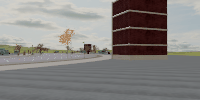

In [2]:
Image(open("demo.gif", 'rb').read(), width=512, height=256)

Besides the newly created `RGBCamera`, there is actually an existing one moving with the car, providing a third person perspective. It is created automatically when launching the rendering service, and captures and renders the content to the main window. Thus the buffer-size for this camera depends on `window_size`. Therefore, you can just use this camera rather than creating a new one. Just set the `image_source=main_camera` and specify the image size with `window_size`. Note that we set `norm_pixel=True` and thus the image pixel value will be unit8 and range from 0 to 255. 

Rendering images and buffering the image observations consume both the GPU and CPU memory of your machine. Please be careful when using this. If you feel the visual data collection is slow, install with advanced offscreen rendering</a>. After verifying your installation, set `config["image_on_cuda"] = True` to get **10x** faster rollout efficiency! It will keep the rendered image on the GPU memory all the time for training, so please ensure your GPU has enough memory to store them. 

### Using semantic camera as observation

{'image': (128, 256, 3, 3)}


(-0.5, 255.5, 127.5, -0.5)

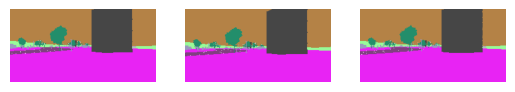

In [4]:
from metaurban.envs import SidewalkStaticMetaUrbanEnv
from metaurban.component.sensors.semantic_camera import SemanticCamera
import matplotlib.pyplot as plt
import os

size = (256, 128) if not os.getenv('TEST_DOC') else (16, 16) # for github CI

env = SidewalkStaticMetaUrbanEnv(dict(
    object_density=0.1,
    log_level=50, # suppress log
    image_observation=True,
    show_terrain=not os.getenv('TEST_DOC'),
    sensors={"sementic_camera": [SemanticCamera, *size]},
    vehicle_config={"image_source": "sementic_camera"},
    stack_size=3,
))
obs, info = env.reset()
for _ in range(5):
    obs, r, d, t, i = env.step((0, 1))

env.close()

print({k: v.shape for k, v in obs.items()})  # Image is in shape (H, W, C, num_stacks)

plt.subplot(131)
plt.imshow(obs["image"][:, :, :, 0])
plt.axis('off')
plt.subplot(132)
plt.imshow(obs["image"][:, :, :, 1])
plt.axis('off')
plt.subplot(133)
plt.imshow(obs["image"][:, :, :, 2])
plt.axis('off')

## TopDownObservation

MetaUrban also supports Top-down semantic m

The following is a minimal script to use Top-down observation.
The `TopDownMetaUrban` is a wrapper class which overrides observation to pygame top-down renderer.
The native observation of this setting is a numpy array with shape `[84, 84, 5]` and all entries fall into [0, 1].
The above figure shows the semantic meaning of each channel.

In [1]:
from metaurban import TopDownMetaUrban

env = TopDownMetaUrban({'object_density': 0.1})
try:
    o,i = env.reset()
    for s in range(1, 100000):
        o, r, tm, tc, info = env.step([0, 1])
        env.render(mode="top_down")
        if tm or tc:
            break
            env.reset()
finally:
    env.close()

[INFO] Environment: TopDownMetaUrban
[INFO] MetaUrban version: 0.0.1
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.0.1
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1
[WARNING] Not set var:walk_on_all_regions, so that agents can walk on all regions (orca_navigation.py:561)
[INFO] Agents can walk on all regions
[INFO] Agents can walk on all regions
[INFO] Episode ended! Scenario Index: 0 Reason: arrive_dest.


## MultiSensor
We encourage users to design observations according to specific demand. We provide a observation space with lidar, rgb, depth and semantic camera.

In [1]:
from metaurban.obs.mix_obs import ThreeSourceMixObservation
from metaurban.component.sensors.depth_camera import DepthCamera
from metaurban.component.sensors.rgb_camera import RGBCamera
from metaurban.component.sensors.semantic_camera import SemanticCamera

sensor_size = (128, 128)
cfg=dict(object_density=0.1,
         agent_observation=ThreeSourceMixObservation,
         image_observation=True,
         sensors={"rgb_camera": (RGBCamera, *sensor_size),
                  "depth_camera": (DepthCamera, *sensor_size),
                  "semantic_camera": (SemanticCamera, *sensor_size)},
         log_level=50) # turn off log

Once finishing the setup, the following code will launch the simulation and show you the image observations returned by `env.step()`, which should contain images from three cameras.

In [4]:
from metaurban.utils import generate_gif
from metaurban.envs import SidewalkStaticMetaUrbanEnv
from IPython.display import Image
import numpy as np
import cv2

frames = []
env=SidewalkStaticMetaUrbanEnv(cfg)
try:
    env.reset()
    print("Observation shape: \n", env.observation_space)
    for step in range(150):
        o, r, d, _, _ = env.step([0,0.5]) # simulation
        
        # visualize image observation
        o_1 = o["depth"][..., -1]
        o_1 = np.concatenate([o_1, o_1, o_1], axis=-1) # align channel
        o_2 = o["image"][..., -1]
        o_3 = o["semantic"][..., -1]
        ret = cv2.hconcat([o_1, o_2, o_3])*255
        ret=ret.astype(np.uint8)
        frames.append(ret[..., ::-1])
        if d:
            break
    generate_gif(frames) # only show 250 frames
finally:
    env.close()

Observation shape: 
 Dict('depth': Box(-0.0, 1.0, (128, 128, 1, 3), float32), 'image': Box(-0.0, 1.0, (128, 128, 3, 3), float32), 'semantic': Box(-0.0, 1.0, (128, 128, 3, 3), float32), 'state': Box(-0.0, 1.0, (271,), float32))


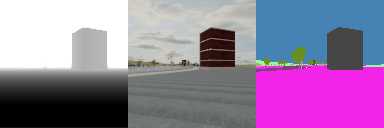

In [5]:
Image(open("demo.gif", 'rb').read(), width=256*3, height=128)